<center><h1> PDI - Production et Distribution Intégré </h1></center>
<center><h3> UE MAOA - Méthodes Avancées et applications industrielles
en Optimisation Combinatoire et en OrdonnAncement </h3></center>

<i>Etudiants :
 - Thomas Corcoral
 - Antoine Toullalan</i>

Si vous lancez les algorithmes pour la première fois, ajoutez l'installation des différentes dépendances ex :<br />
<code>import Pkg
Pkg.add("FileIO")
</code>

<h3>Introduction</h3>
<p> 
Afin de résoudre le problème de production et distribution intégré, nous allons mettre en place 2 algorithmes. Un premier reposant sur un mixte entre PLNE et heuristiques. Et un second ne faisant appel qu'à un PLNE (utilisant un branch & cut)
</p>

<h4>Méthode utilisant des heuristiques</h4>
    1. PLNE pour le problème de Lot sizing<br />
    2. Heuristique gloutonne (BP, CW, Sectorielle) pour le VRP<br />
    3. TSP & ajustement des lots pour les tournées
<h4>PLNE</h4>
    1. Reproduction de l'article suivant : Y. Adulyasak and J-F Cordeau and R. Jans (2015). The production routing problem: A review of formulations and solution algorithms Computers & Operations Research,
55:141-152.<br />
    2. Ajout du Branch & cut

In [1]:
import Pkg
#Pkg.add("Plots")
#Pkg.add("Compose")
#Pkg.add("Fontconfig")
#Pkg.add("Colors")
#Pkg.add("IterTools")
#Pkg.add("Combinatorics")
#Pkg.add("DataFrames")
#Pkg.add("ProgressBars")
using Plots
using FileIO
using ProgressBars

<h2>1. Méthode heuristique </h2>

### 1.1 Présentation graphique des résultats

In [2]:
using FileIO
include("src/Heuristic/PDI.jl")

get_vrp_cost (generic function with 1 method)

In [3]:
path = "PRP_instances/"
file = "A_014_ABS1_15_3"
# file = "A_100_ABS94_100_1"
# file = "B_050_instance5"
# file = "B_200_instance16"

# h = "BP"
h = "CW"
# h = "SECT"

"CW"

t 2 : 


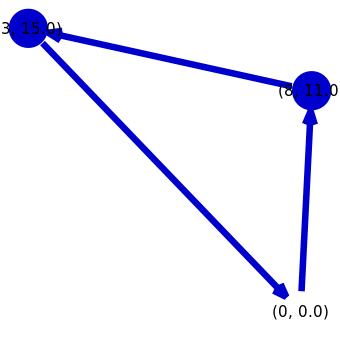

--------------------------------------------------------------------------------------------
t 3 : 


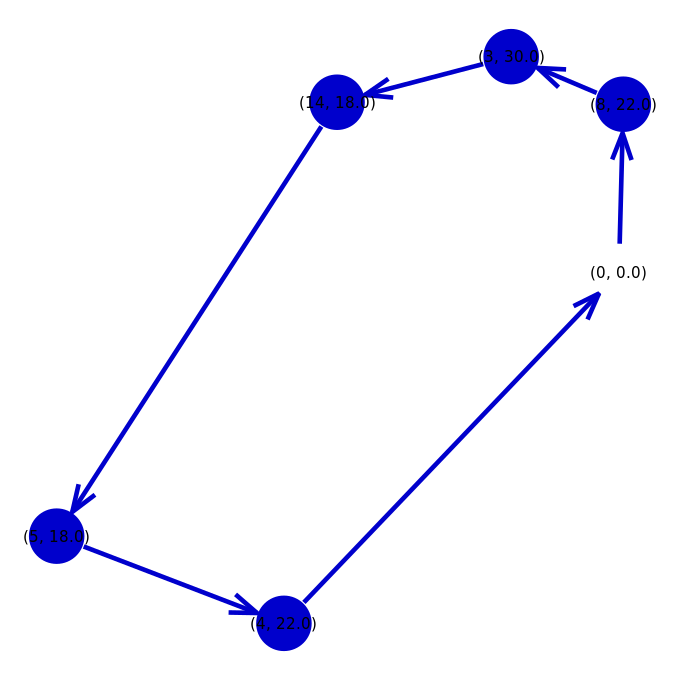

--------------------------------------------------------------------------------------------
t 5 : 


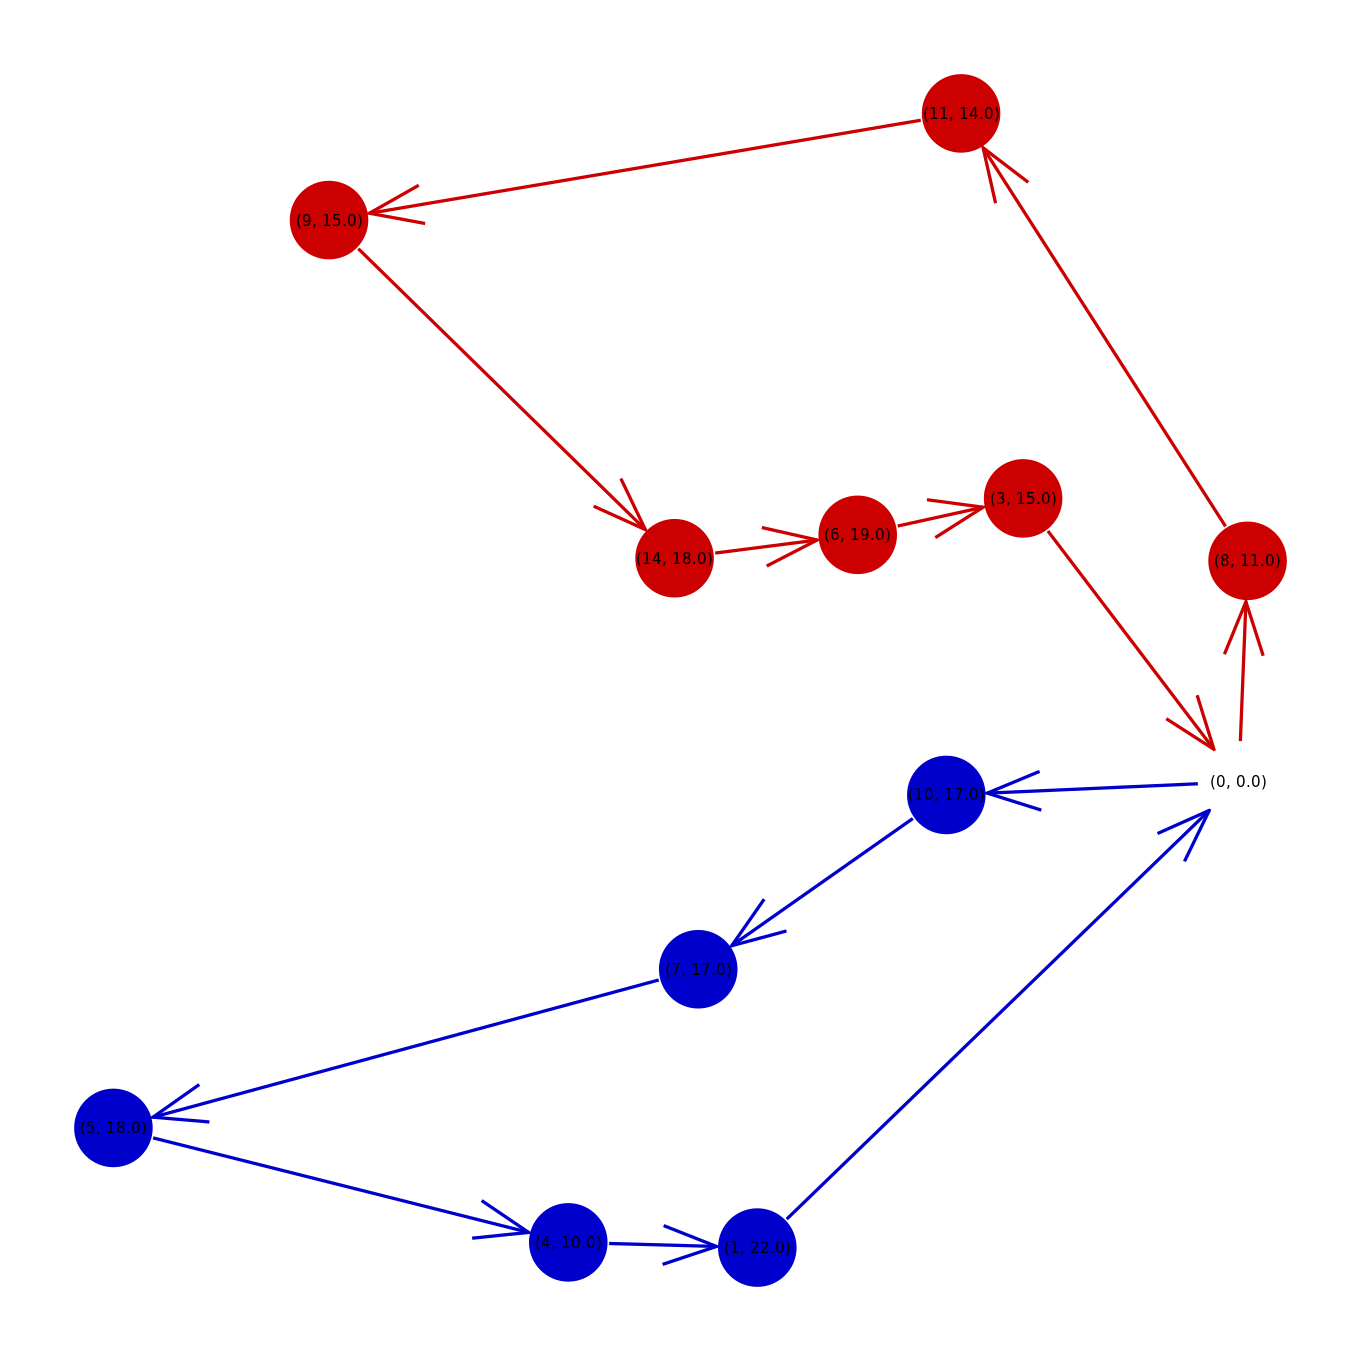

--------------------------------------------------------------------------------------------
t 6 : 


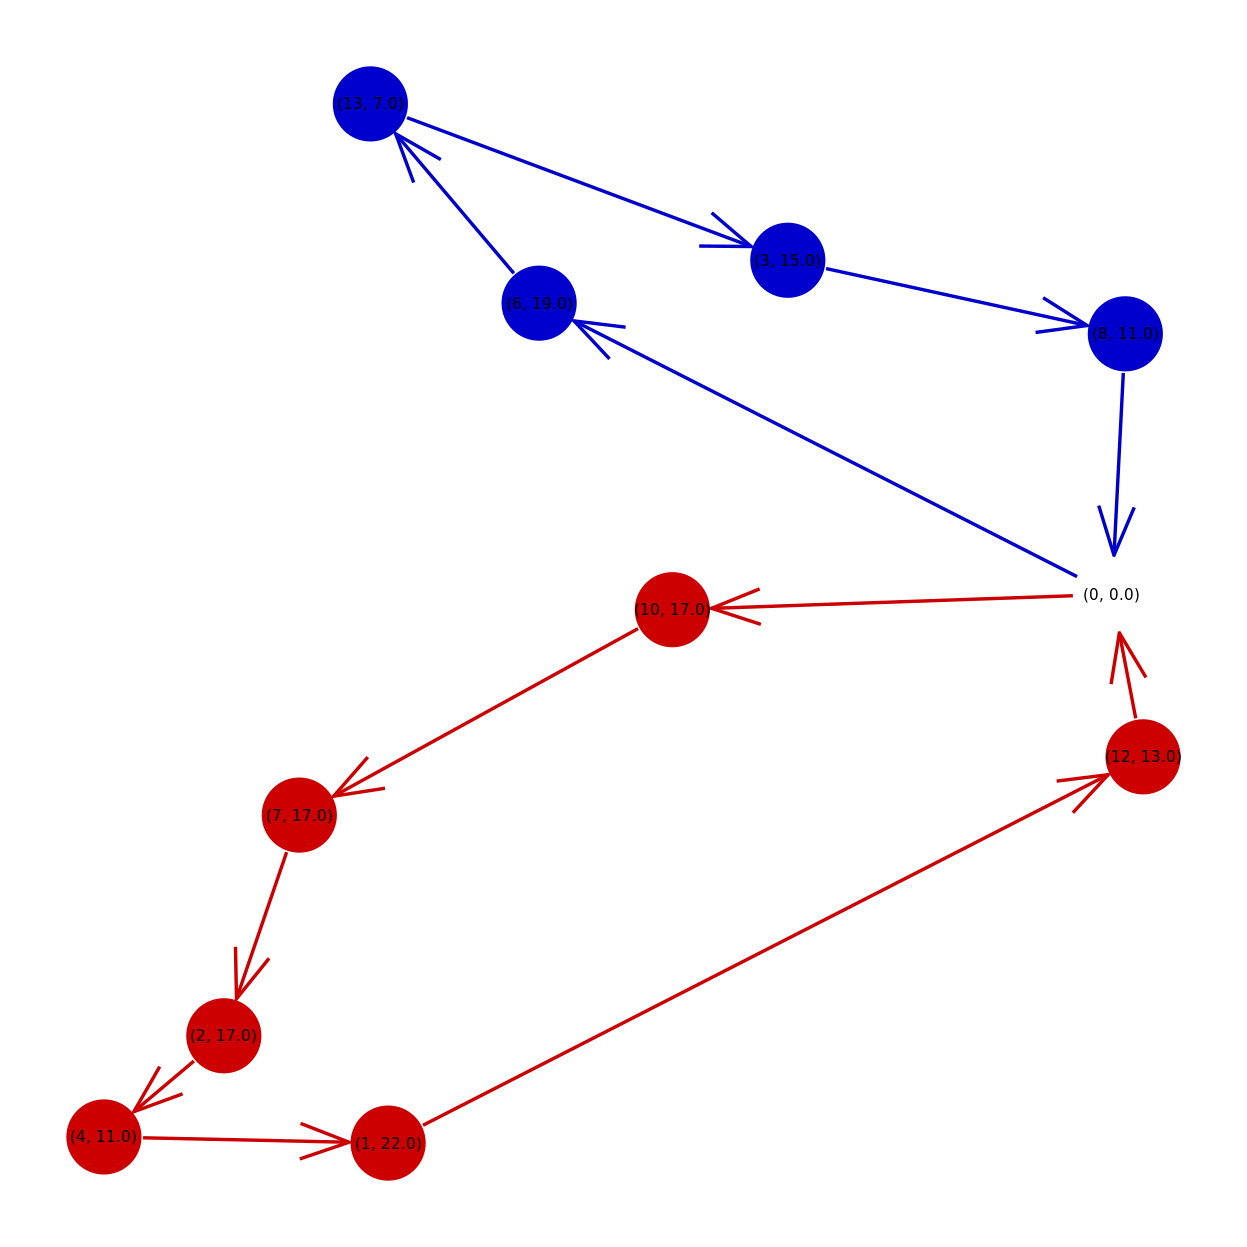

--------------------------------------------------------------------------------------------
Cost : 31867.0


In [5]:
f = string(path, file, ".prp")
(cost, l), time_h = @timed PDI_H(f, h)
for t in 1:l
    t_file = "log/" * file * "/t_" * string(t) * ".png"
    if isfile(t_file)
        println("t " * string(t) * " : ")
        display("image/png", read(t_file))
        println("--------------------------------------------------------------------------------------------")
    end
end
println("Cost : " * string(cost))

In [6]:
println(string("Cout heuristique ", h, " : ", cost))
println(string("Temps d'exec heuristique ", h, " : ", time_h))

Cout heuristique CW : 31867.0
Temps d'exec heuristique CW : 20.787385616


### 1.2 Generation de données 

In [32]:
include("src/Experiences/test_pdi.jl")

test_heuristics_csv (generic function with 1 method)

In [36]:
extra_files = ["A_050_ABS27_50_3.prp",
               "A_100_ABS5_100_4.prp",
               "B_050_instance1.prp",
               "B_100_instance1.prp",
               "B_200_instance1.prp"]
extra_files = [] # To Deactivate /\
extra_files = ["B_050_instance1.prp",
               "B_100_instance1.prp",]

2-element Vector{String}:
 "B_050_instance1.prp"
 "B_100_instance1.prp"

In [37]:
test_heuristics_csv(0, "PRP_instances/", extra_files)

0.0%┣                                                ┫ 0/2 [00:00<00:00, -0s/it]
50.0%┣█████████████████████▌                     ┫ 1/2 [03:15<Inf:Inf, InfGs/it]
100.0%┣█████████████████████████████████████████████┫ 2/2 [11:05<00:00, 665s/it]
100.0%┣█████████████████████████████████████████████┫ 2/2 [11:05<00:00, 665s/it]


Row,file,BP_score,CW_score,SECT_score,BP_time,CW_time,SECT_time
,Any,Any,Any,Any,Any,Any,Any
1,B_050_instance1.prp,1.10116e6,1.20551e6,9.97695e5,46.8016,45.8186,51.1126
2,B_100_instance1.prp,1.99352e6,1.73009e6,2.40996e6,185.257,193.952,90.241


<h2>2. PLNE</h2>

### 2.1 Présentation graphique des résultats

In [4]:
include("src/PLNE/PDI_BC.jl")
include("src/readPRP.jl")

Read_PRP_instance (generic function with 2 methods)

In [5]:
#path = "PRP_instances/"
#file = "A_014_ABS1_15_3"
# file = "A_050_ABS7_50_5"
# file = "A_100_ABS94_100_1"
# file = "B_050_instance5"
# file = "B_200_instance16"

In [6]:
f = string(path, file, ".prp")
prp = Read_PRP_instance(f)
(p_dec, y_dec, I_dec, q_dec, x_dec, l, n, ccc), time_pl = @timed PDI_BC(prp)
q_dec = q_dec[2:end, 1:end]
println(string("temps exec : ", time_pl))

temps exec : 18.21353241


In [7]:
lots = []
graphs = []
for t in 1:l
    lot = []
    ii = 0
    for i in 1:n+1
        for j in 1:n+1
            if x_dec[i,j,t] == 1
                append!(lot, [(i, j)])
                ii = ii + 1
            end
        end
    end
    append!(lots, [lot])
    if ii != 0
        ll = Edge.(lot)
        g = SimpleDiGraph(ll)
        append!(graphs, [g])
    end
end

In [8]:
i = 1
t = 1
res = []
for lot in lots
    if length(lot) != 0
        c = simplecycles(graphs[i])
        for cycle in 1:length(c)
            for node in 1:length(c[cycle])
                c[cycle][node] -= 1
            end
        end
        i += 1
        append!(res, [c])
    else
        append!(res, [[]])
    end
    t += 1
end
print(res)

Any[Any[], [[0, 8, 3]], [[0, 4, 5, 14, 3, 8]], Any[], [[0, 10, 7, 2, 1, 4, 5, 9, 11, 13, 14, 6, 3, 8]], [[0, 12]]]

In [12]:
using Dates
include("src/draw.jl")
date, f_cost = string(Dates.now()), 0

for t in 1:l
    if res[t] != []
        pdi_to_png(prp, q_dec, t, res[t], file, date)
        f_cost += get_vrp_cost(prp, res[t])
    end
end

t 2 : 


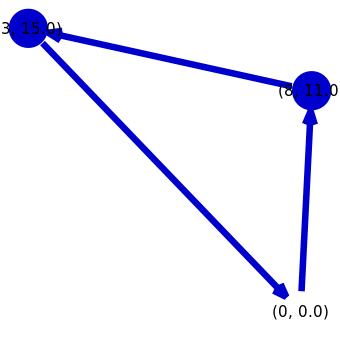

--------------------------------------------------------------------------------------------
t 3 : 


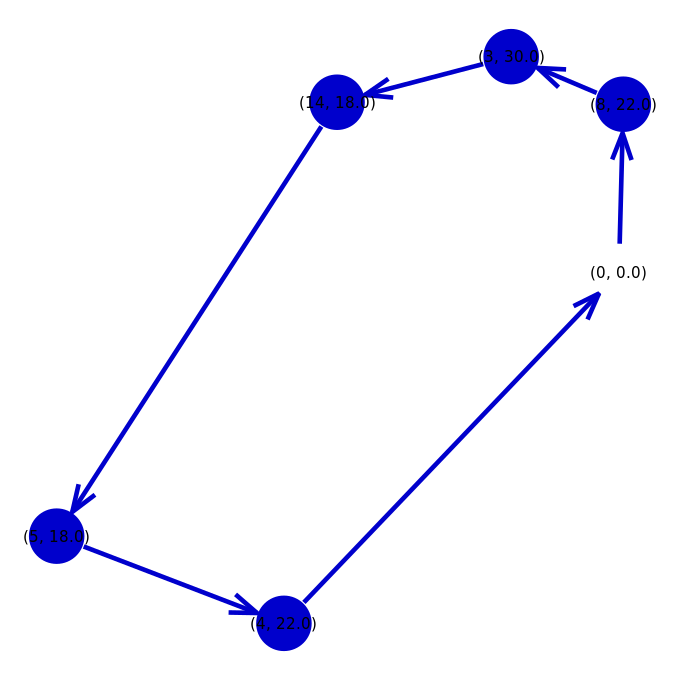

--------------------------------------------------------------------------------------------
t 5 : 


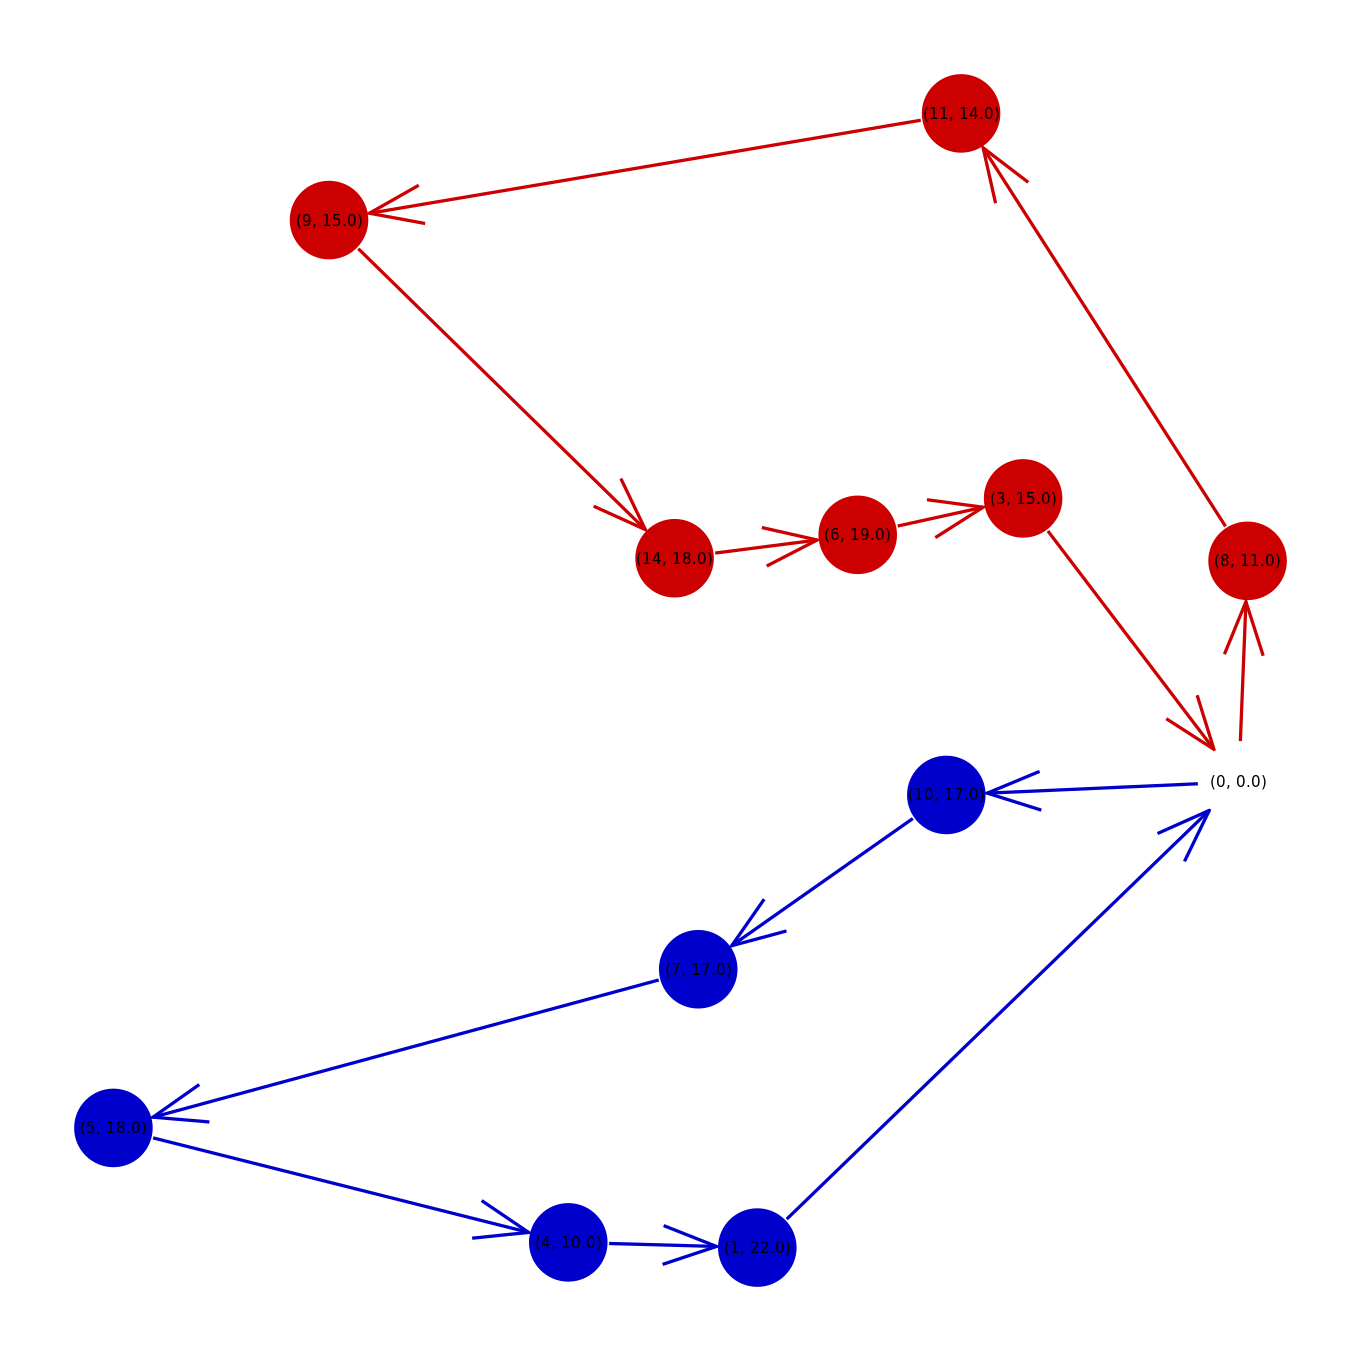

--------------------------------------------------------------------------------------------
t 6 : 


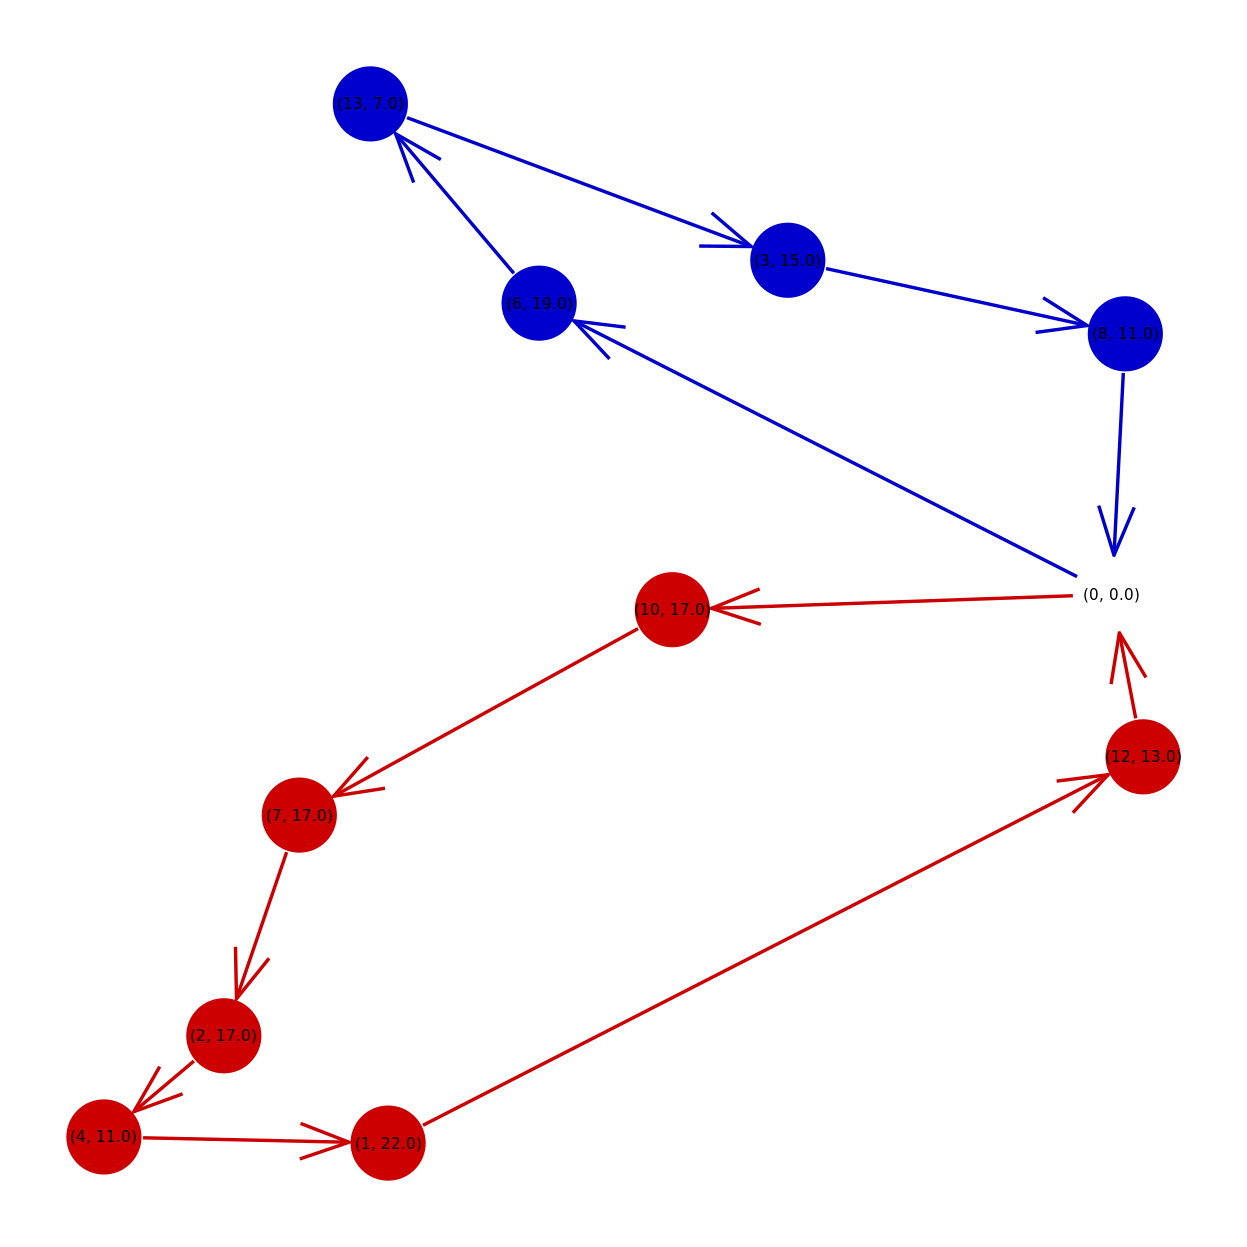

--------------------------------------------------------------------------------------------
Cost : 31107.0


In [10]:
for t in 1:l
    t_file = "log/" * file * "/t_" * string(t) * ".png"
    if isfile(t_file)
         println("t " * string(t) * " : ")
        display("image/png", read(t_file))
        println("--------------------------------------------------------------------------------------------")
    end
end
println(string("Cost : ", ccc))

In [11]:
println(string("Cost PLNE : ", ccc))
print(string("temps exec : ", time_pl))

Cost PLNE : 31107.0
temps exec : 18.21353241

### 2.2 Generation de données 

In [28]:
include("src/Experiences/test_pdi_plne.jl")

   Resolving package versions...
  No Changes to `~/Documents/master/MAOA/julia-1.8.2/.julia_commun_a_tous/environments/v1.8/Project.toml`
  No Changes to `~/Documents/master/MAOA/julia-1.8.2/.julia_commun_a_tous/environments/v1.8/Manifest.toml`


test_heuristics_csv (generic function with 1 method)

In [29]:
test_heuristics_csv(20, "PRP_instances", extra_files)

0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
5.0%┣██▏                                        ┫ 1/20 [00:42<Inf:Inf, InfGs/it]
10.0%┣████▋                                         ┫ 2/20 [00:46<13:57, 46s/it]
15.0%┣███████                                       ┫ 3/20 [00:58<08:15, 29s/it]
20.0%┣█████████▏                                    ┫ 4/20 [01:01<05:25, 20s/it]
25.0%┣███████████▌                                  ┫ 5/20 [01:35<05:57, 24s/it]
30.0%┣█████████████▌                               ┫ 6/20 [08:40<24:15, 104s/it]
35.0%┣████████████████                              ┫ 7/20 [08:53<19:15, 89s/it]
40.0%┣██████████████████▍                           ┫ 8/20 [09:08<15:39, 78s/it]
45.0%┣████████████████████▊                         ┫ 9/20 [09:10<12:36, 69s/it]
50.0%┣██████████████████████▌                      ┫ 10/20 [14:52<16:31, 99s/it]
55.0%┣████████████████████████▏                   ┫ 11/20 [17:42<15:56, 106s/it]
60.0%┣██████████████████████

Row,file,PLNE_score,PLNE_time
,Any,Any,Any
1,A_014_#ABS1_15_1.prp,40390.0,37.8862
2,A_014_ABS10_15_1.prp,72875.0,4.76903
3,A_014_ABS10_15_2.prp,61809.0,11.7506
4,A_014_ABS10_15_3.prp,53958.0,2.61286
5,A_014_ABS10_15_4.prp,66253.0,34.3993
6,A_014_ABS10_15_5.prp,62115.0,424.281
7,A_014_ABS11_15_1.prp,72813.0,13.4897
8,A_014_ABS11_15_2.prp,61908.0,15.0133
9,A_014_ABS11_15_3.prp,54052.0,2.04528
